_____________________________________________________________________________________________

Her er hele vores Python-fil:
_____________________________________________________________________________________________

In [34]:
from types import SimpleNamespace

import numpy as np
from scipy import optimize

import pandas as pd 
import matplotlib.pyplot as plt

class HouseholdSpecializationModelClass:

    def __init__(self):
        """ setup model """

        # a. create namespaces
        par = self.par = SimpleNamespace()
        sol = self.sol = SimpleNamespace()

        # b. preferences
        par.rho = 2.0
        par.nu = 0.001
        par.epsilon = 1.0
        par.omega = 0.5 

        # c. household production
        par.alpha = 0.5
        par.sigma = 1.0

        # d. wages
        par.wM = 1.0
        par.wF = 1.0
        par.wF_vec = np.linspace(0.8,1.2,5)

        # e. targets
        par.beta0_target = 0.4
        par.beta1_target = -0.1

        # f. solution
        sol.LM_vec = np.zeros(par.wF_vec.size)
        sol.HM_vec = np.zeros(par.wF_vec.size)
        sol.LF_vec = np.zeros(par.wF_vec.size)
        sol.HF_vec = np.zeros(par.wF_vec.size)

        sol.beta0 = np.nan
        sol.beta1 = np.nan

    def calc_utility(self,LM,HM,LF,HF):
        """ calculate utility """

        par = self.par
        sol = self.sol

        # a. consumption of market goods
        C = par.wM*LM + par.wF*LF

        # b. home production
        H = np.nan

        power = (par.sigma - 1)/par.sigma

        if par.sigma == 1:
            H = HM**(1-par.alpha)*HF**par.alpha
        elif par.sigma == 0:
            H = np.fmin(HM, HF)
        else: 
            H = (  (1-par.alpha)  * (HM+0.00000000001) **(power) + par.alpha * (HF+0.0000000001)**(power)  )**(1/power)

        # c. total consumption utility
        Q = C**par.omega*H**(1-par.omega)
        utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)

        # d. disutlity of work
        epsilon_ = 1+1/par.epsilon
        TM = LM+HM
        TF = LF+HF
        disutility = par.nu*(TM**epsilon_/epsilon_+TF**epsilon_/epsilon_)
        
        return utility - disutility

    def solve_discrete(self,do_print=False):
        """ solve model discretely """
        
        par = self.par
        sol = self.sol
        opt = SimpleNamespace()
        
        # a. all possible choices
        x = np.linspace(0,24,49)
        LM,HM,LF,HF = np.meshgrid(x,x,x,x) # all combinations
    
        LM = LM.ravel() # vector
        HM = HM.ravel()
        LF = LF.ravel()
        HF = HF.ravel()

        # b. calculate utility
        u = self.calc_utility(LM,HM,LF,HF)
    
        # c. set to minus infinity if constraint is broken
        I = (LM+HM > 24) | (LF+HF > 24) # | is "or"
        u[I] = -np.inf
    
        # d. find maximizing argument
        j = np.argmax(u)
        
        opt.LM = LM[j]
        opt.HM = HM[j]
        opt.LF = LF[j]
        opt.HF = HF[j]

        # e. print
        if do_print:
            for k,v in opt.__dict__.items():
                print(f'{k} = {v:6.4f}')

        return opt



    def solve(self,do_print=False):
        """ solve model continously """

        par = self.par
        sol = self.sol
        opt = SimpleNamespace()
    
    # a. objective function 
        def obj(x):
            LM, HM, LF, HF = x
            return - self.calc_utility(LM, HM, LF, HF)
    
    #b. Constraints and Bounds (to minimize) 
        def constraints(x):
            LM, HM, LF, HF = x
            return [24 - LM-HM, 24 -LF-HF]
    

        constraints = ({'type': 'ineq', 'fun':constraints}) 
        bounds = ((0,24), (0,24), (0,24), (0,24))

        initial_guess = [6,6,6,6]

    #c. Solver 
        solution = optimize.minimize(obj, initial_guess, method="SLSQP", bounds=bounds, constraints=constraints, tol = 0.000000001)

        opt.LM = solution.x[0]
        opt.HM = solution.x[1]
        opt.LF = solution.x[2]
        opt.HF = solution.x[3]
        
        return opt






    def solve_wF_vec(self,discrete=False):
        """ solve model for vector of female wages """
        
        par = self.par
        sol = self.sol
        
        results = np.zeros(par.wF_vec.size)

        for i, wF in enumerate(par.wF_vec):
            par.wF = wF
            
            opt = self.solve()
            
            sol.HM = opt.HM
            sol.HF = opt.HF
            results[i] = sol.HF/sol.HM
            #print(f' the optimal male hours at home and at the job are {opt.HM:2f} and {opt.LM:2f} while for the female {opt.HF:2f} and {opt.LF:2f}')

        sol.results = results

        return results

        #return opt.LM, opt.HM, opt.LF, opt.HF 


    def solve_wF_vec_2(self,discrete=False):
        """ solve model for vector of female wages """
        
        par = self.par
        sol = self.sol

        for i, wF in enumerate(par.wF_vec):
            par.wF = wF
            
            opt = self.solve()

            sol.LM_vec[i] = opt.LM
            sol.HM_vec[i] = opt.HM
            sol.LF_vec[i] = opt.LF
            sol.HF_vec[i] = opt.HF

        return sol 



    
    def run_regression(self):
        """ run regression """
        
        #Setting up parameters
        par = self.par
        sol = self.sol
        
        #Running regression
        x = np.log(par.wF_vec)
        y = np.log(sol.HF_vec/sol.HM_vec)
        A = np.vstack([np.ones(x.size),x]).T
        sol.beta0,sol.beta1 = np.linalg.lstsq(A,y,rcond=None)[0]
        return sol 



    def estimate(self,alpha=None,sigma=None):
        """ estimate alpha and sigma """

        pass

_____________________________________________________________________________________________

Importer nødvendige pakker:
_____________________________________________________________________________________________

In [35]:
import numpy as np
from types import SimpleNamespace

import numpy as np
from scipy import optimize

import pandas as pd 
import matplotlib.pyplot as plt

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


_____________________________________________________________________________________________

Question 1
_____________________________________________________________________________________________

In [36]:
model = HouseholdSpecializationModelClass()

par = model.par

list_alpha = [0.25, 0.5, 0.75]
list_sigma = [0.5, 1.0, 1.5]

#Kode som løser det forholdet mellem timer for de forskellige værder af alpha og sigma:

for i in list_sigma:
    par.sigma = i
    for j in list_alpha:
        par.alpha = j
        opt = model.solve_discrete()
        
        relative_hours = opt.HF/opt.HM
        print(f' For sigma = {par.sigma:.2f} and alpha = {par.alpha:.2f}, the relative hours in a discrete setting at home are: {relative_hours:.2f}')


 For sigma = 0.50 and alpha = 0.25, the relative hours in a discrete setting at home are: 0.55
 For sigma = 0.50 and alpha = 0.50, the relative hours in a discrete setting at home are: 1.00
 For sigma = 0.50 and alpha = 0.75, the relative hours in a discrete setting at home are: 1.83
 For sigma = 1.00 and alpha = 0.25, the relative hours in a discrete setting at home are: 0.31
 For sigma = 1.00 and alpha = 0.50, the relative hours in a discrete setting at home are: 1.00
 For sigma = 1.00 and alpha = 0.75, the relative hours in a discrete setting at home are: 3.25
 For sigma = 1.50 and alpha = 0.25, the relative hours in a discrete setting at home are: 0.21
 For sigma = 1.50 and alpha = 0.50, the relative hours in a discrete setting at home are: 1.00
 For sigma = 1.50 and alpha = 0.75, the relative hours in a discrete setting at home are: 4.67


For at gøre det mere overskueligt laver vi en tabel. Det er de samme værdier som ovenfor, som vi rapporterer:

In [37]:
#Calculating a table with optimal relative hours worked at home 
model_1 = HouseholdSpecializationModelClass()
par = model_1.par
sol = model_1.sol

#List of paramters to solve for 
list_alpha = [0.25, 0.5, 0.75]
list_sigma = [0.5, 1.0, 1.5]

# empty list to store the relative wage values
table_data = []

# loop alpha values
for alpha in list_alpha:
    # row list for the current alpha value
    row_data = []
    
    # loop  sigma values
    for sigma in list_sigma:
        # parameter values
        par.alpha = alpha
        par.sigma = sigma
        
        # solve for optimal solution
        opt = model_1.solve_discrete()
        
        # calculate relative wage and append to row list
        relative_wage = opt.HF / opt.HM
        row_data.append(relative_wage)
    
    # append the row list to the table data list
    table_data.append(row_data)

# create a pandas DataFrame from the table data
table = pd.DataFrame(table_data, index=list_alpha, columns=list_sigma)

# print the table
print(table)

           0.5       1.0       1.5
0.25  0.545455  0.307692  0.214286
0.50  1.000000  1.000000  1.000000
0.75  1.833333  3.250000  4.666667


Kommentarer til resultat:
Når alpha stiger kommer forholdet mellem HF og HM til at stige. Det forventes også, da funktionen H er stigende i alpha for alle værdier af sigma in {0.5, 1.0, 1.5}.


_____________________________________________________________________________________________

Question 2
_____________________________________________________________________________________________

In [38]:
model_2 = HouseholdSpecializationModelClass()

par = model_2.par

results_q2 = []

#Løser modellen diskret for forskellige forhold mellem WF og WM
for i in par.wF_vec:
    par.wF = i
    opt = model_2.solve_discrete()
        
    relative_hours = opt.HF/opt.HM
    log_relative_h = np.log(relative_hours)
    results_q2 = np.append(results_q2, log_relative_h)
    print(f'For a relative wage ratio of {i:2f} the optimal relative hours at home are (HF/HM) {relative_hours:3f}')

For a relative wage ratio of 0.800000 the optimal relative hours at home are (HF/HM) 1.250000
For a relative wage ratio of 0.900000 the optimal relative hours at home are (HF/HM) 1.000000
For a relative wage ratio of 1.000000 the optimal relative hours at home are (HF/HM) 1.000000
For a relative wage ratio of 1.100000 the optimal relative hours at home are (HF/HM) 0.888889
For a relative wage ratio of 1.200000 the optimal relative hours at home are (HF/HM) 0.800000


Herunder kode, som laver en figur med resultaterne ovenfor:

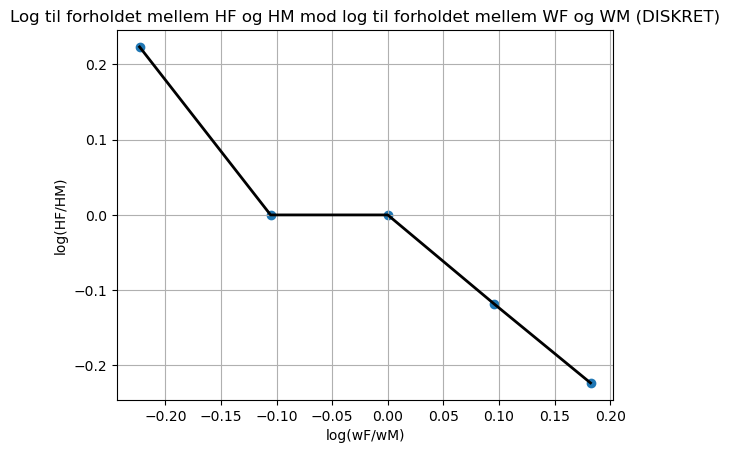

In [39]:
# create figure
fig = plt.figure()
# create plot
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.log(par.wF_vec), results_q2, color='black', lw=2)
ax.scatter(np.log(par.wF_vec), results_q2)
# alterations to figure
ax.grid()
ax.set_xlabel("log(wF/wM)")
ax.set_ylabel("log(HF/HM)")
ax.set_title("Log til forholdet mellem HF og HM mod log til forholdet mellem WF og WM (DISKRET)")
plt.show()

Kommentarer til resultatet:
I tråd med vores forventinger kommer forholdet HF/HM til at falde, når forholdet WF/WM stiger. Altså når kvindens løn stiger, så vil hendes hjemmelige produktion falde. Det sker fordi kvinden nu kan tjene flere penge ved at arbejde og alternativomkostningen da er større ved husligt arbejde, og den samlede nytte stiger da, hvis kvinden arbejder mere og får løn (som kan bruges på forbrug) i stedet for at producere hjemmeligt arbejde.
Knækket omkring log(HF/HM)=0 kommer, fordi modellen her er formuleret diskret.

Question 3

In [40]:
model_3 = HouseholdSpecializationModelClass()

par = model_3.par

results_q3 = []

#Løser modellen kontinuerligt for forskellige forhold mellem WF og WM
for i in par.wF_vec:
    par.wF = i
    opt = model_3.solve()
        
    relative_hours = opt.HF/opt.HM
    log_relative_h = np.log(relative_hours)
    results_q3 = np.append(results_q3, log_relative_h)
    print(f'For a relative wage ratio of {i:2f} the optimal relative hours at home are (HF/HM) {relative_hours:3f}')

print(results_q3)
print(np.log(par.wF_vec))


For a relative wage ratio of 0.800000 the optimal relative hours at home are (HF/HM) 1.250018
For a relative wage ratio of 0.900000 the optimal relative hours at home are (HF/HM) 1.111080
For a relative wage ratio of 1.000000 the optimal relative hours at home are (HF/HM) 1.000000
For a relative wage ratio of 1.100000 the optimal relative hours at home are (HF/HM) 0.909123
For a relative wage ratio of 1.200000 the optimal relative hours at home are (HF/HM) 0.833341
[ 2.23157756e-01  1.05332807e-01 -2.22044605e-16 -9.52743339e-02
 -1.82312759e-01]
[-0.22314355 -0.10536052  0.          0.09531018  0.18232156]


In [41]:
def solve_wF_vec(self,discrete=False):
    """ solve model for vector of female wages """
    par = self.par
    sol = self.sol
    for it, w in enumerate(par.wF_vac):
        par.wF = w
        if discrete == True:
            res = self.solve_discrete()
        else:
            res = self.solve()
        sol.LM_vec[it] = res.LM
        sol.LF_vec[it] = res.LF
        sol.HM_vec[it] = res.HM
        sol.HF_vec[it] = res.HF


Igen laver vi en figur for at vise resultaterne:

[-0.22314355 -0.10536052  0.          0.09531018  0.18232156]
[ 2.23157756e-01  1.05332807e-01 -2.22044605e-16 -9.52743339e-02
 -1.82312759e-01]


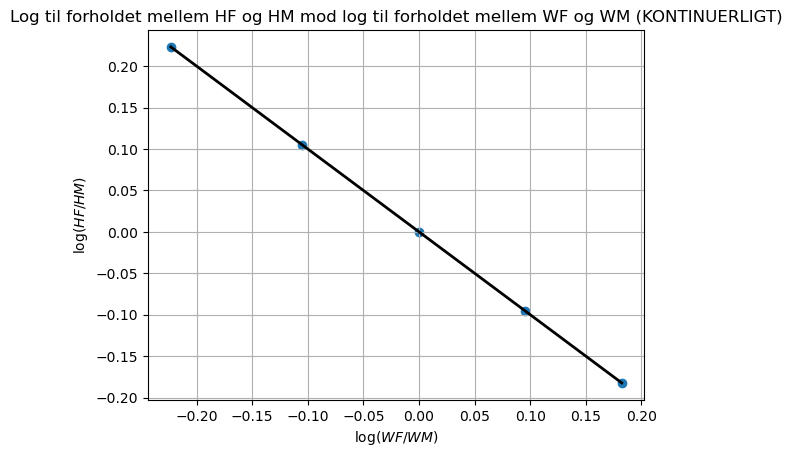

In [42]:
# create figure
model_3 = HouseholdSpecializationModelClass()
par = model_3.par

relative_hours = np.log(model_3.solve_wF_vec() )

relative_wage = np.log(par.wF_vec / par.wM)
print(relative_wage)
print(relative_hours)


fig = plt.figure()
# create plot
ax = fig.add_subplot(1, 1, 1)
ax.plot(relative_wage, relative_hours, color='black', lw=2)
ax.scatter(relative_wage, relative_hours)
# alterations to figure
ax.grid(True)
plt.xlabel('$\log(WF / WM)$')
plt.ylabel('$\log(HF/HM)$')
ax.set_title("Log til forholdet mellem HF og HM mod log til forholdet mellem WF og WM (KONTINUERLIGT)")
plt.show()

Kommentarer til resultatet:
Vi ser (naturligvis) samme tendens som i det diskrete tilfælde. Der er dog ikke noget "knæk" omkring log(HF/HM)=0, da agenten nu kan vælge sin tid kontinuerligt i stedet for et diskret. 

_____________________________________________________________________________________________

Question 4
_____________________________________________________________________________________________

Wht the inital values of alpha and sigma the regression gives the coefisients:
Beta0_hat =  0.00
Beta1_hat =  -1.00


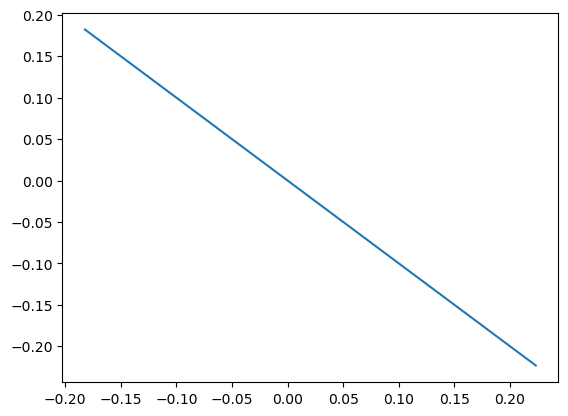

In [43]:
#Running regresion for the current alpha / sigma value 
model_4 =HouseholdSpecializationModelClass()

#Unpacking 
par = model_4.par
sol = model_4.sol



#Solving for relative wage
model_4.solve_wF_vec_2()
#Running regression 
model_4.run_regression()


print (f'Wht the inital values of alpha and sigma the regression gives the coefisients:')
print(f"Beta0_hat =  {sol.beta0:.2f}")
print(f"Beta1_hat =  {sol.beta1:.2f}")


#Unødvendigt 
x = np.log(par.wF_vec)
y = np.log(sol.HF_vec/sol.HM_vec)
y_hat = sol.beta0 + sol.beta1 * x


plt.plot(y_hat, x)

Herover et plot af det som Siminski og Yetsenga (2022) fandt

In [44]:
model_4 =HouseholdSpecializationModelClass()

par = model_4.par
sol = model_4.sol

def obj(par_2):
    par.alpha, par.beta = par_2
    model_4.solve_wF_vec_2()
    model_4.run_regression()

    err =  (par.beta0_target - sol.beta0)**2 + (par.beta1_target-sol.beta1)**2
    return err
    #return (par.beta0_target - sol.beta0)**2 + (par.beta1_target-sol.beta1)**2

bounds = [(0, 1),(0.01, 2)]
#bounds = [(0.5,0.99),(0.01, 0.3)]
initial_guess = [0.5, 1]
#initial_guess = [0.8, 0.1]


reg_opt = optimize.minimize(obj, initial_guess, method='Nelder-Mead', bounds=bounds, tol = 0.000000001) #Hvis tolerancen er høj, accepterer den løsninger som kun er tæt på at være rigtige



alpha_hat = reg_opt.x[0]
sigma_hat = reg_opt.x[1]

err = obj(reg_opt.x)



print (f'Minimizing the squared errrors gives the regressio:')
print(f"    Beta0_hat =  {sol.beta0:.2f}")
print(f"    Beta1_hat =  {sol.beta1:.2f}")

print(f'This gives the parameters: \n    alpha = {alpha_hat:.2f} \n    beta = {sigma_hat:.2f}')
print(f' With the squared error {err:.2f}')

Minimizing the squared errrors gives the regressio:
    Beta0_hat =  0.42
    Beta1_hat =  -0.99
This gives the parameters: 
    alpha = 0.60 
    beta = 0.95
 With the squared error 0.80


Her en estimation af, hvordan det ser ud i vores tilfælde. Beta0_hat=0.42 passer godt med Beta0=0.4 og Beta1_hat=-0.99 passer knap så godt med Beta1=-0.1.

Kommentarer til resultater:
Beta0_hat=0.42 indikrerer, at HF som udgangspunkt er større end HM. Altså at kvinder laver mere husligt arbejde end mænd som udgangspunkt.

For Beta1_hat=-0.99
Hvis man arbejder med Beta1_hat=-0.99 (som i modellen i opgaven) vil en stigning i forholdet WF/WM på 10% give anledning til at forholdet i HF/HM falder med 9,9% (altså næsten 1 til 1). Så hvis kvinden begynder at tjene mere, så skifter den relative arbejdsbyrde i hjemmet med sammen forhold, som det lønforholdet er blevet ændret med.

For Beta1=-0.1
Hvis man arbejder med Beta1=-0.1 (som i Siminski and Yetsenga) vil en stigning i forholdet WF/WM på 10% give anledning til at forholdet i HF/HM falder med 1% (altså 1 til 10). Så hvis kvinden begynder at tjene mere, så skifter den relative arbejdsbyrde i hjemmet med 1/10 af det forhold, som lønforholdet er blevet ændret med.
